# BTC-USD @24h

In [75]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
SP500_FILENAME = './data_clean/sp500.csv'
OUT_FILENAME = './results/btc24h_ohlcw_sp500.csv'
OUT_RETRAINED_FILENAME = './results/btc24h_ohlcw_sp500.ret.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [45]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

In [47]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


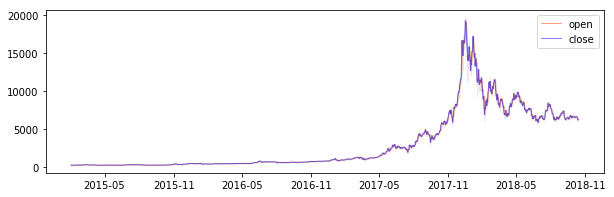

In [48]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

In [49]:
data24h['weekday'] = data24h.index.dayofweek
data24h.head()

,close,open,high,low,volume,missing,weekday
datetime,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3


> size: 933


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-02,2020.85,1996.67,2021.66,1980.90,NaN,0
2015-02-03,2050.03,2022.71,2050.30,2022.71,NaN,0
2015-02-04,2041.51,2048.86,2054.74,2036.72,NaN,0
2015-02-05,2062.52,2043.45,2063.55,2043.45,NaN,0
2015-02-06,2055.47,2062.28,2072.40,2049.97,NaN,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-08,2884.43,2877.53,2889.45,2862.08,NaN,0
2018-10-09,2880.34,2882.51,2894.83,2874.27,NaN,0
2018-10-10,2785.68,2873.90,2874.02,2784.86,NaN,0
2018-10-11,2728.37,2776.87,2795.14,2710.51,NaN,0
2018-10-12,2767.13,2770.54,2775.77,2729.44,NaN,0


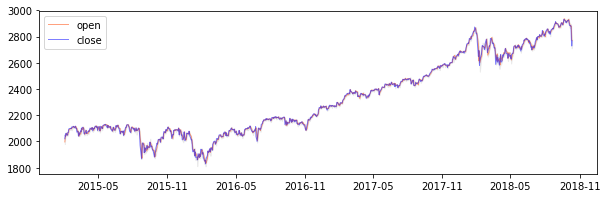

In [51]:
data_sp500 = pd.read_csv(
    SP500_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data_sp500))
dd(data_sp500.dtypes)
dd(data_sp500.head())
dd(data_sp500.tail())
simple_plot(data_sp500, show_xlabels=False)

In [55]:
data = etl.augment(data24h, data_sp500, 7, '_sp500')
data.head(10)

,close,open,high,low,volume,missing,weekday,close_sp500,slope_sp500,r2_sp500
datetime,,,,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6,NaN,0.000000e+00,0.000000
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0,2020.85,0.000000e+00,0.000000
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1,2050.03,0.000000e+00,0.000000
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2,2041.51,0.000000e+00,0.000000
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3,2062.52,0.000000e+00,0.000000
2015-02-06,222.9,216.8,225.9,214.9,4.73,0,4,2055.47,0.000000e+00,0.000000
2015-02-07,228.6,223.4,231.1,221.8,6.36,0,5,NaN,0.000000e+00,0.000000
2015-02-08,224.2,228.3,232.9,219.7,5.46,0,6,NaN,9.459491e-14,0.647589
2015-02-09,220.7,224.2,226.0,215.0,19.48,0,0,2046.74,9.459491e-14,0.647589


## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** Best results at 6 epochs. More consistency at 10 but average quality drops.

data ~ (600, 4)
--- 0.015s to model compilation time


--- Created model id: 140032468972176
Tensor("lstm_1_input:0", shape=(?, 7, 4), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 7)              336       
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7)                 420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 764
Trainable params: 764
Non-trainable params: 0
____________________________________________________________

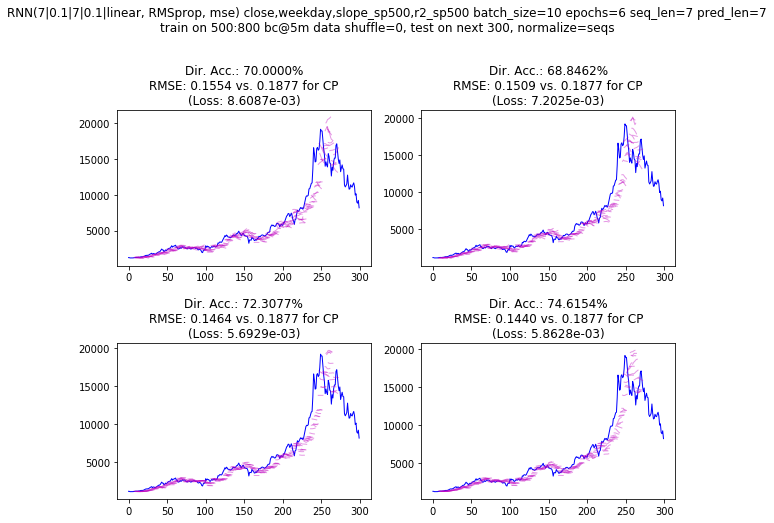

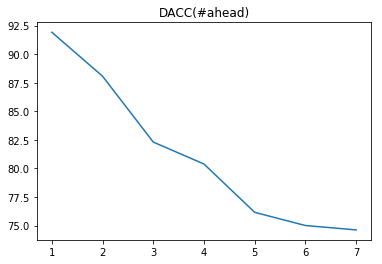

--- 33.890s to run experiment



In [57]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140029987916112
Tensor("lstm_17_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_17 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_18 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
___________________________________________________________

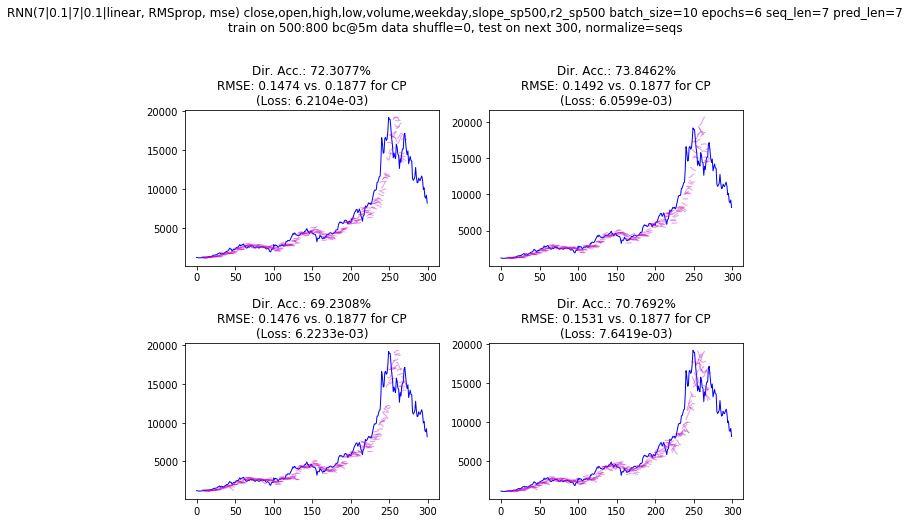

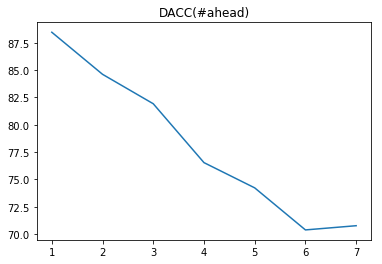

--- 40.938s to run experiment



In [59]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 8)
--- 0.016s to model compilation time


--- Created model id: 140028956027536
Tensor("lstm_107_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_107 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_107 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_108 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_108 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
__________________________________________________________

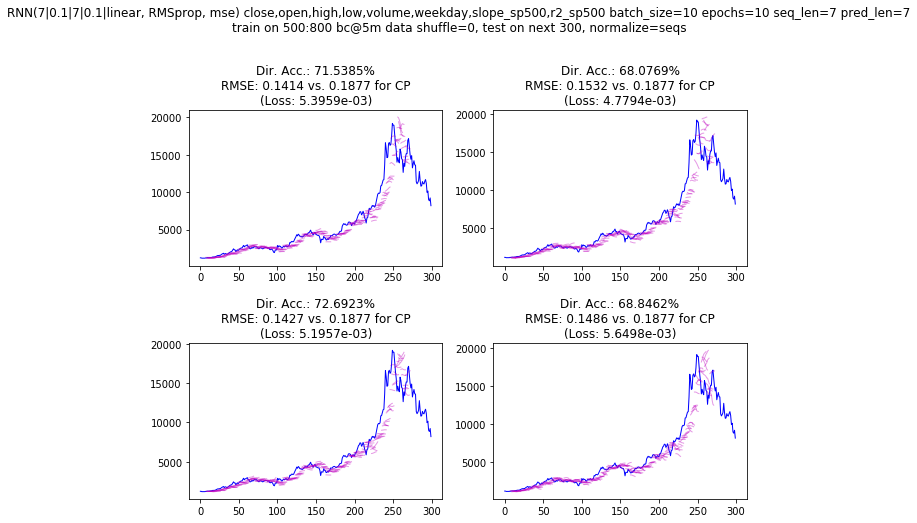

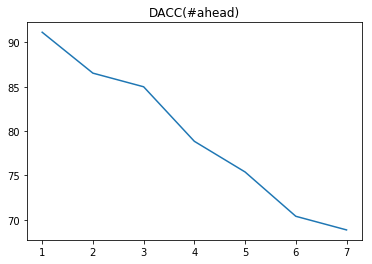

--- 90.639s to run experiment



In [71]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (1200, 8)
--- 0.015s to model compilation time


--- Created model id: 140029899531472
Tensor("lstm_25_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 7, 7)              448       
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_26 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
__________________________________________________________

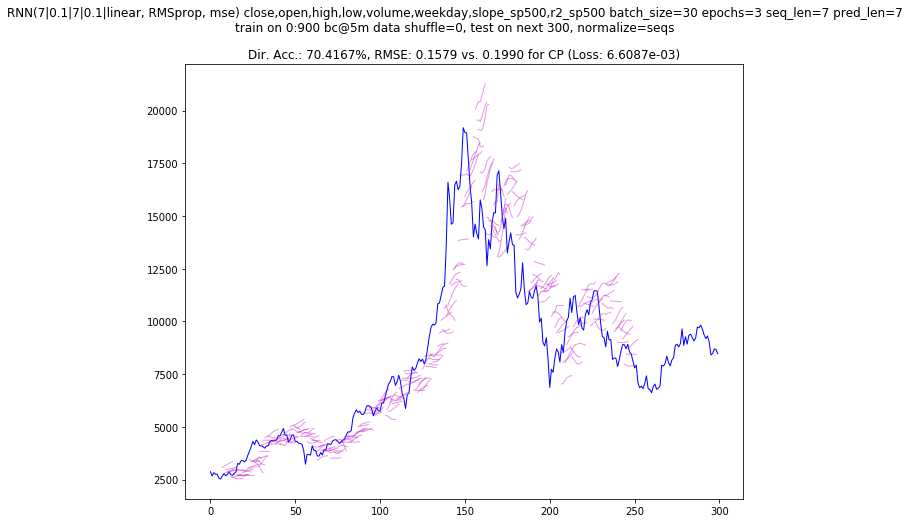

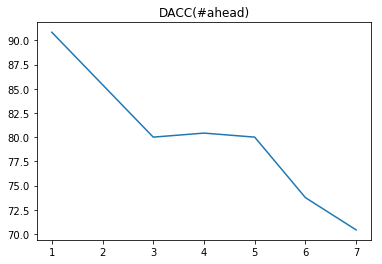

--- 8.216s to run experiment



In [60]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=900,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=3,
        batch_size=30,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 3|0.1|3|0.1

**Conclusion:** 3 epochs best.

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140029871901072
Tensor("lstm_27_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 7, 3)              144       
_________________________________________________________________
dropout_27 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_28 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 4         
Total params: 232
Trainable params: 232
Non-trainable params: 0
___________________________________________________________

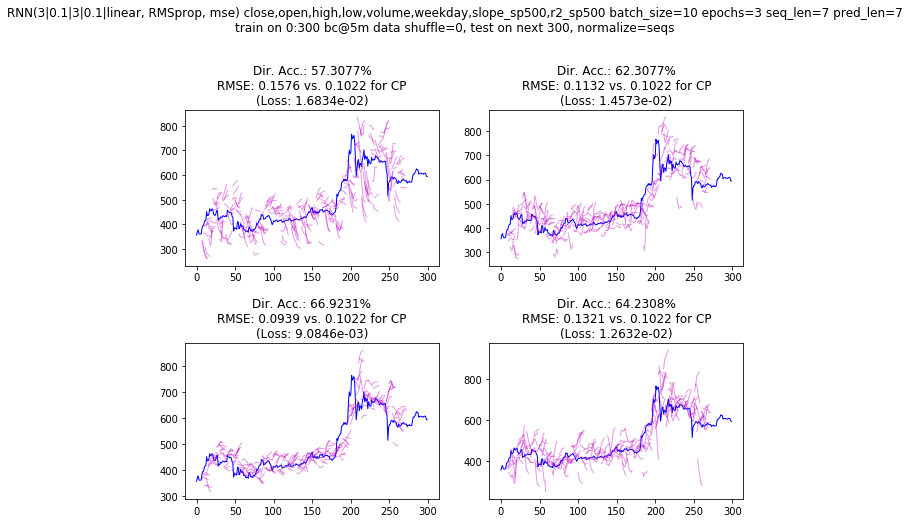

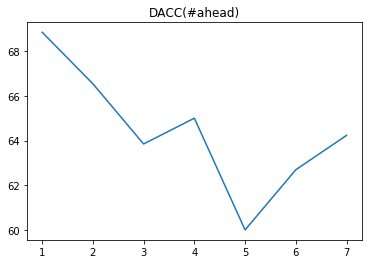

--- 37.589s to run experiment



In [61]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 8)
--- 0.016s to model compilation time


--- Created model id: 140029785112208
Tensor("lstm_35_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 7, 3)              144       
_________________________________________________________________
dropout_35 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_36 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 4         
Total params: 232
Trainable params: 232
Non-trainable params: 0
___________________________________________________________

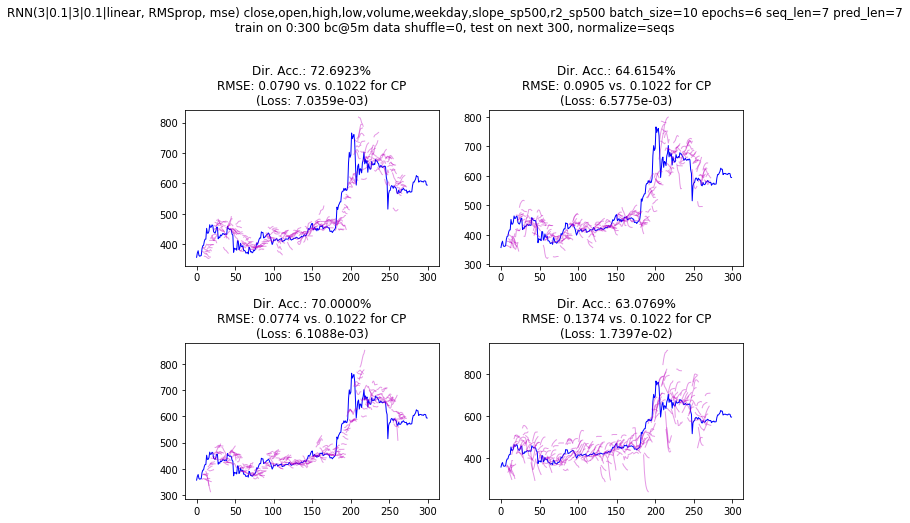

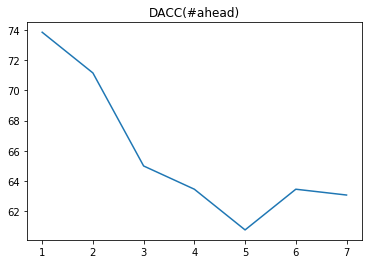

--- 49.773s to run experiment



In [62]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 8)
--- 0.016s to model compilation time


--- Created model id: 140029589585680
Tensor("lstm_51_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 7, 3)              144       
_________________________________________________________________
dropout_51 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dropout_52 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 4         
Total params: 232
Trainable params: 232
Non-trainable params: 0
___________________________________________________________

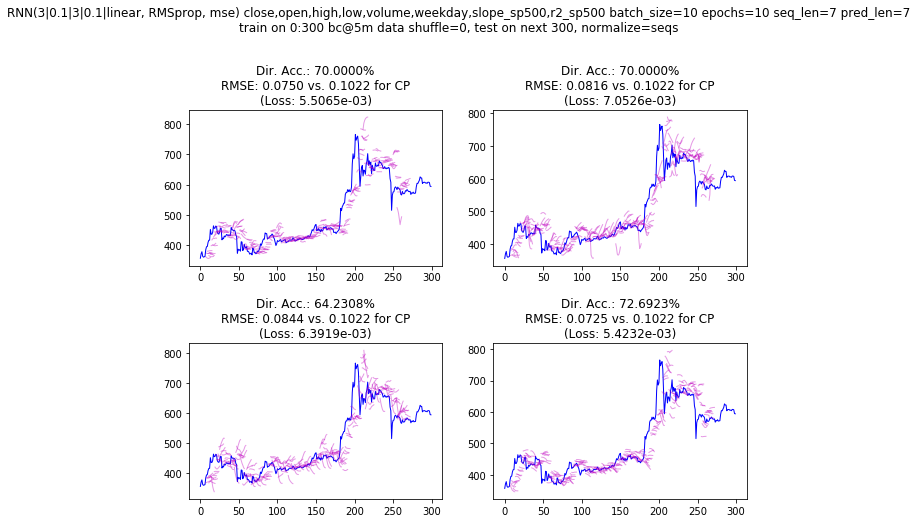

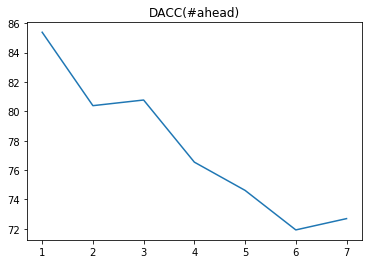

--- 66.435s to run experiment



In [64]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 14|0.1|14|0.1

**Conclusion:** Not better results than smaller networks?

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140029515635536
Tensor("lstm_59_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 7, 14)             1288      
_________________________________________________________________
dropout_59 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_60 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 15        
Total params: 2,927
Trainable params: 2,927
Non-trainable params: 0
_______________________________________________________

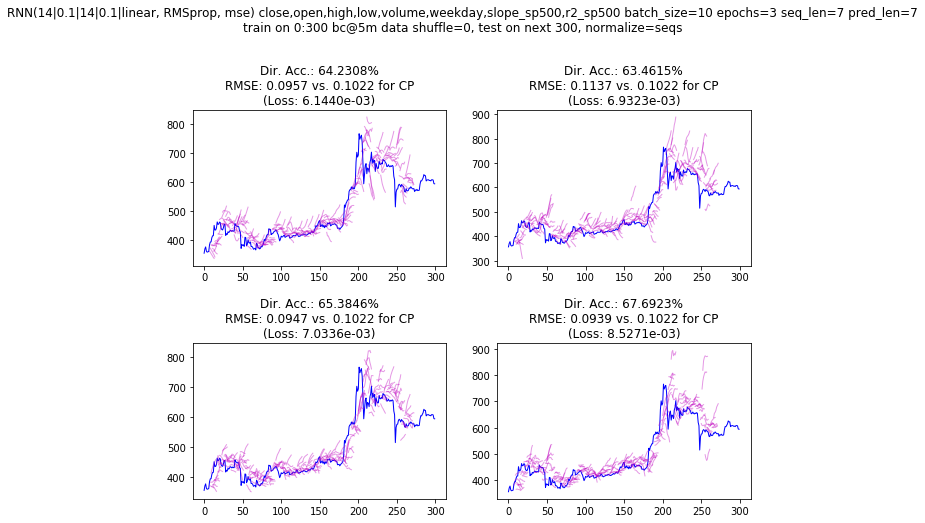

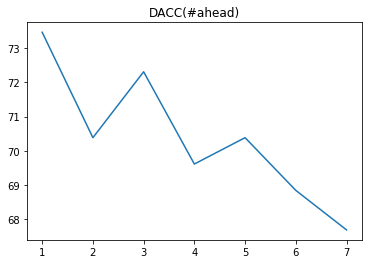

--- 52.347s to run experiment



In [65]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140029422952272
Tensor("lstm_67_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 7, 14)             1288      
_________________________________________________________________
dropout_67 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_68 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 15        
Total params: 2,927
Trainable params: 2,927
Non-trainable params: 0
_______________________________________________________

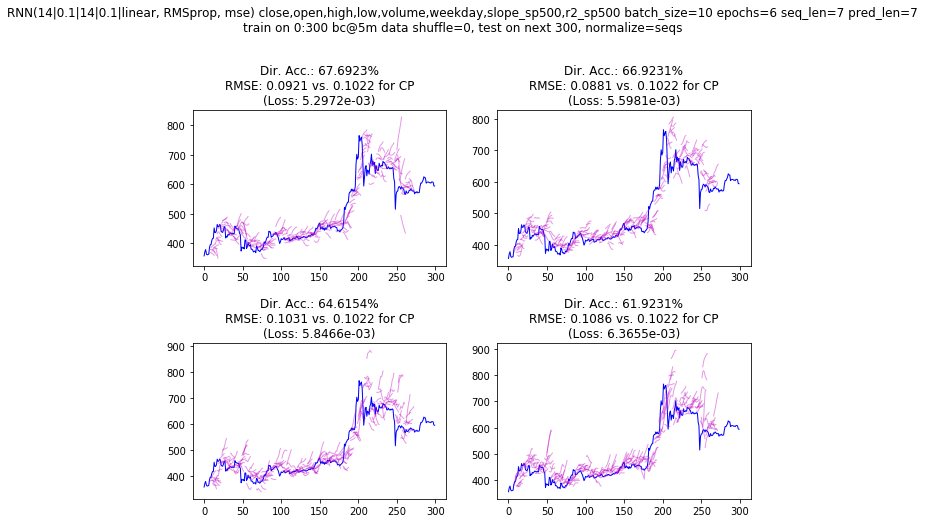

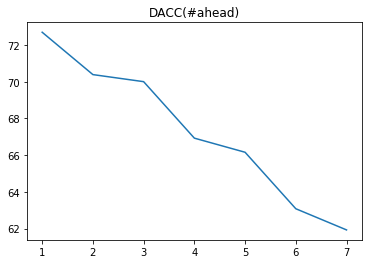

--- 61.869s to run experiment



In [66]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140029318624336
Tensor("lstm_75_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 7, 14)             1288      
_________________________________________________________________
dropout_75 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_76 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 15        
Total params: 2,927
Trainable params: 2,927
Non-trainable params: 0
_______________________________________________________

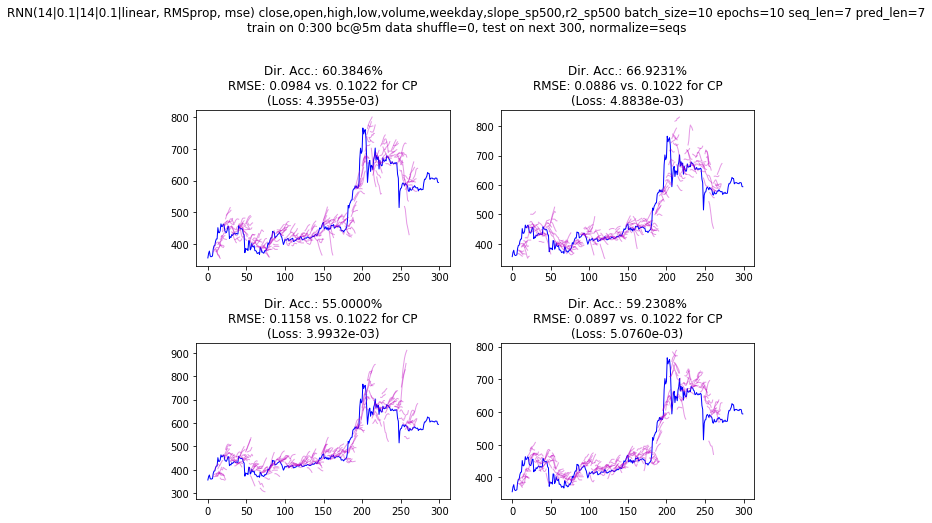

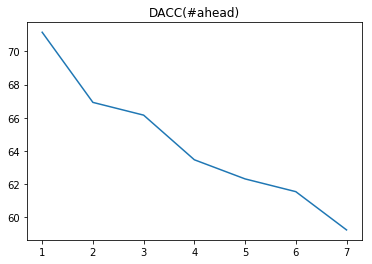

--- 77.066s to run experiment



In [67]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140029242471760
Tensor("lstm_83_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 7, 14)             1288      
_________________________________________________________________
dropout_83 (Dropout)         (None, 7, 14)             0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 14)                1624      
_________________________________________________________________
dropout_84 (Dropout)         (None, 14)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 15        
Total params: 2,927
Trainable params: 2,927
Non-trainable params: 0
_______________________________________________________

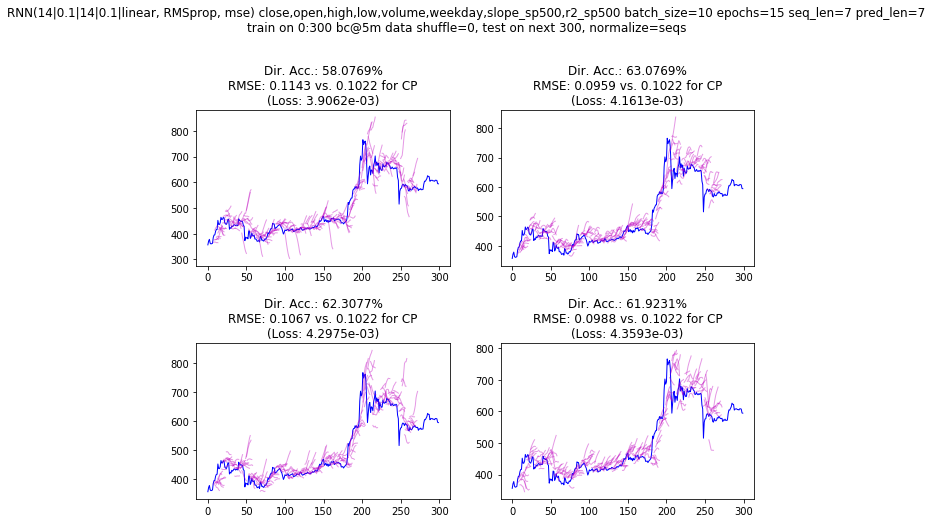

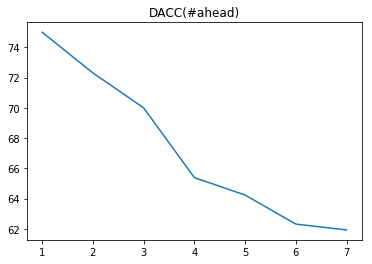

--- 91.352s to run experiment



In [68]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=15,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 30|0.1|30|0.1

**Conclusion:** Really bad results, best at 3-6 epochs but comparatively too bad to worth condiering this further.

data ~ (900, 8)
--- 0.015s to model compilation time


--- Created model id: 140029134705872
Tensor("lstm_91_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 7, 30)             4680      
_________________________________________________________________
dropout_91 (Dropout)         (None, 7, 30)             0         
_________________________________________________________________
lstm_92 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dropout_92 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 31        
Total params: 12,031
Trainable params: 12,031
Non-trainable params: 0
_____________________________________________________

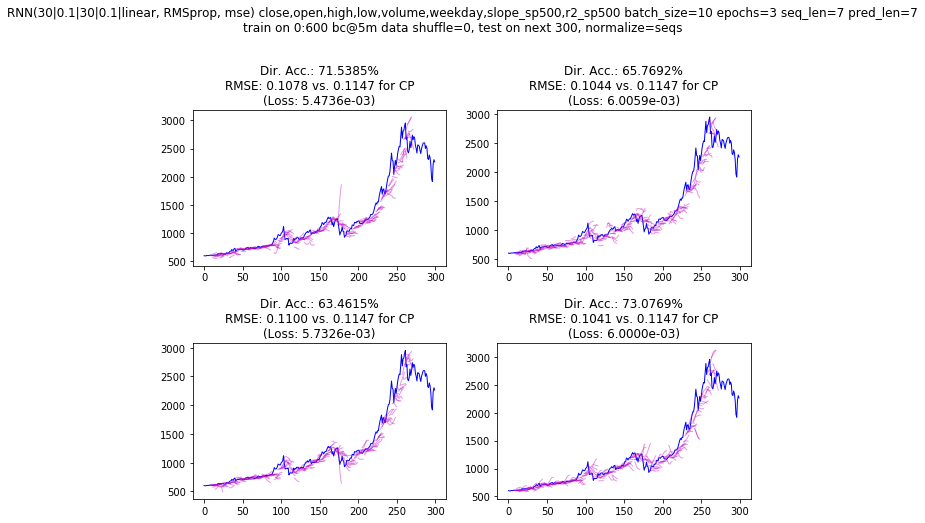

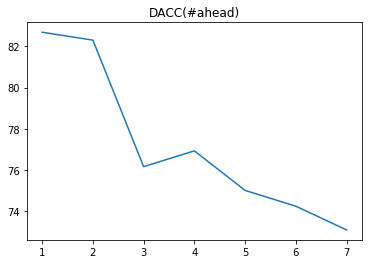

--- 75.519s to run experiment



In [69]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=600,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([30, 0.1, 30, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (900, 8)
--- 0.015s to model compilation time


--- Created model id: 140029061944720
Tensor("lstm_99_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 7, 30)             4680      
_________________________________________________________________
dropout_99 (Dropout)         (None, 7, 30)             0         
_________________________________________________________________
lstm_100 (LSTM)              (None, 30)                7320      
_________________________________________________________________
dropout_100 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 31        
Total params: 12,031
Trainable params: 12,031
Non-trainable params: 0
_____________________________________________________

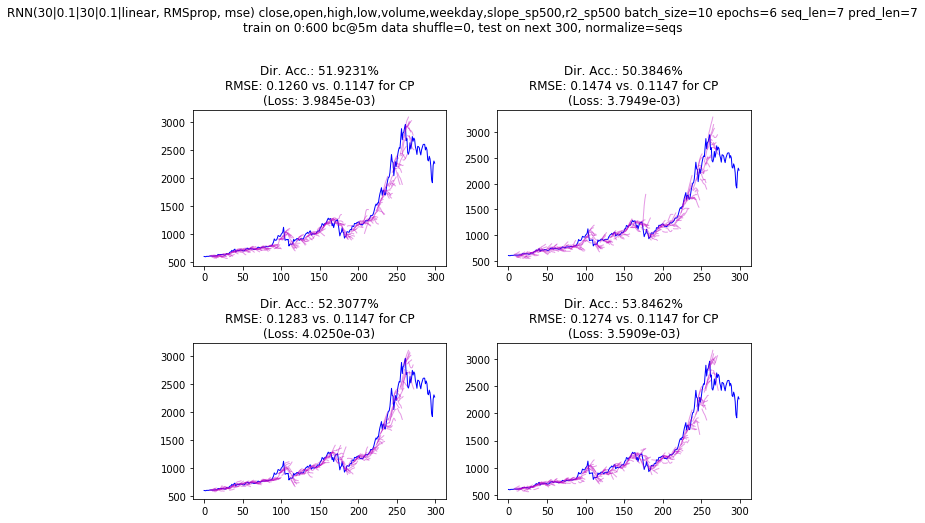

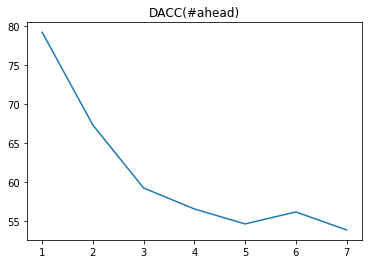

--- 92.416s to run experiment



In [70]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data,
        features=['close', 'open', 'high', 'low', 'volume', 'weekday',
                  'slope_sp500', 'r2_sp500'],
        from_i=0,
        train_sz=600,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([30, 0.1, 30, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

## Full runs

In [86]:
DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data,
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([7, 0.1, 7, 0.1]),
    # training:
    'epochs': 6,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [80]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [81]:
def full_run(idx_from, idx_to, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(OUT_FILENAME, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()

In [85]:
### wiithout "bad performing" feature (high, low, volume):


   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 4)
--- 0.015s to model compilation time


--- Created model id: 140028738981712
Tensor("lstm_127_input:0", shape=(?, 7, 4), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_127 (LSTM)              (None, 7, 7)              336       
_________________________________________________________________
dropout_127 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_128 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_128 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 8         
Total params: 764
Trainable params: 764
Non-trainable params: 0
__

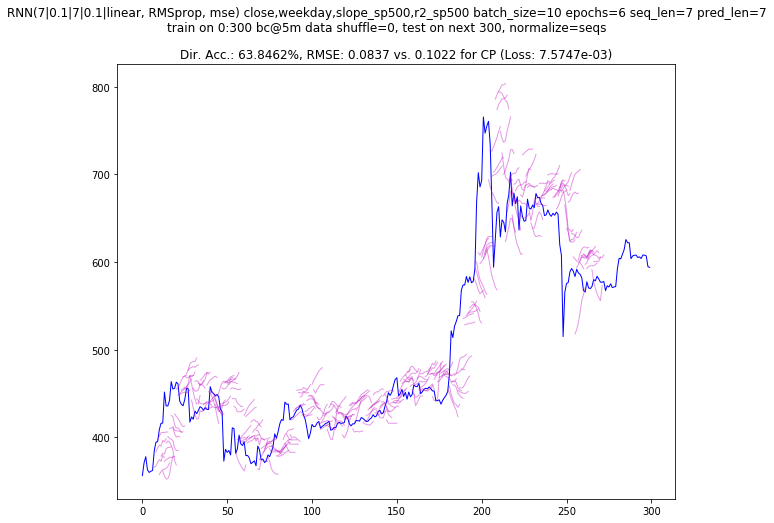

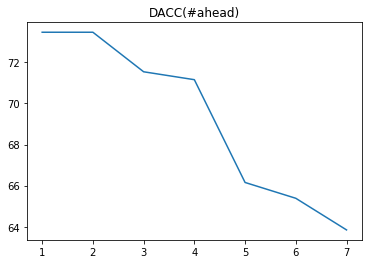

--- 22.075s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 4)
--- 0.016s to model compilation time


--- Created model id: 140028739033872
Tensor("lstm_129_input:0", shape=(?, 7, 4), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_129 (LSTM)              (None, 7, 7)              336       
_________________________________________________________________
dropout_129 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_130 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_130 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 8         
Total params: 764
Trainable params: 

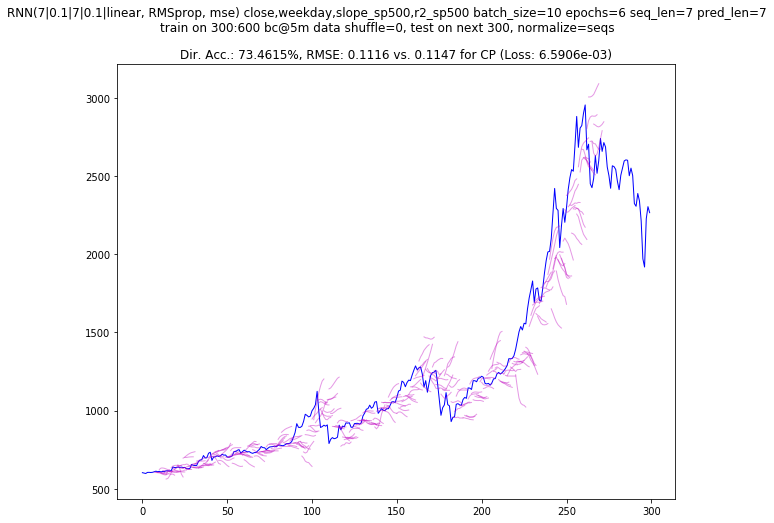

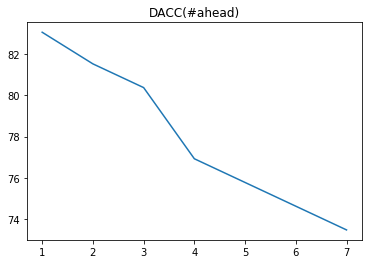

--- 22.177s to run segment


   ------ RUN 900 (from 600, train on 300, test on 300)

data ~ (600, 4)
--- 0.015s to model compilation time


--- Created model id: 140028710891920
Tensor("lstm_131_input:0", shape=(?, 7, 4), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 7, 7)              336       
_________________________________________________________________
dropout_131 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_132 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_132 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 8         
Total params: 764
Trainable params: 

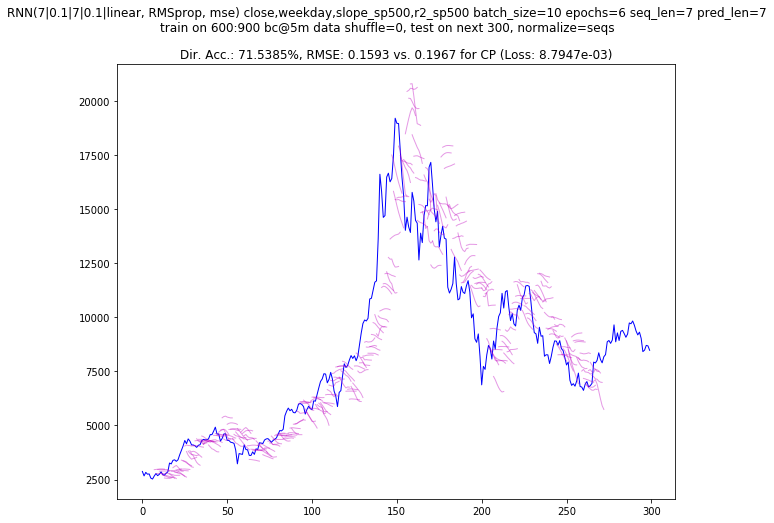

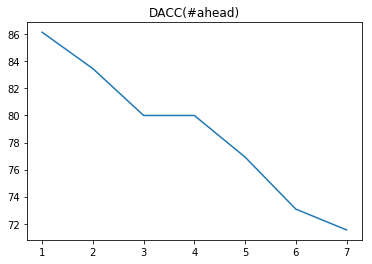

--- 22.430s to run segment

--- 66.682s to full run 300 - 1051



In [87]:
DEFAULT_PARAMS['features'] = ['close', 'weekday',
#                  'open', 'high', 'low', 'volume',
                 'slope_sp500', 'r2_sp500'], 
full_run(300, 1051, write_csv_header=True)

In [89]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",0,300,300,False,seqs,0.007575,0.0837%,0.1022%,63.8462%
1,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",300,600,300,False,seqs,0.006591,0.1116%,0.1147%,73.4615%
2,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",600,900,300,False,seqs,0.008795,0.1593%,0.1967%,71.5385%



   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140032475644944
Tensor("lstm_133_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_133 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_133 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_134 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_134 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 876
Non-trainable params: 0
__

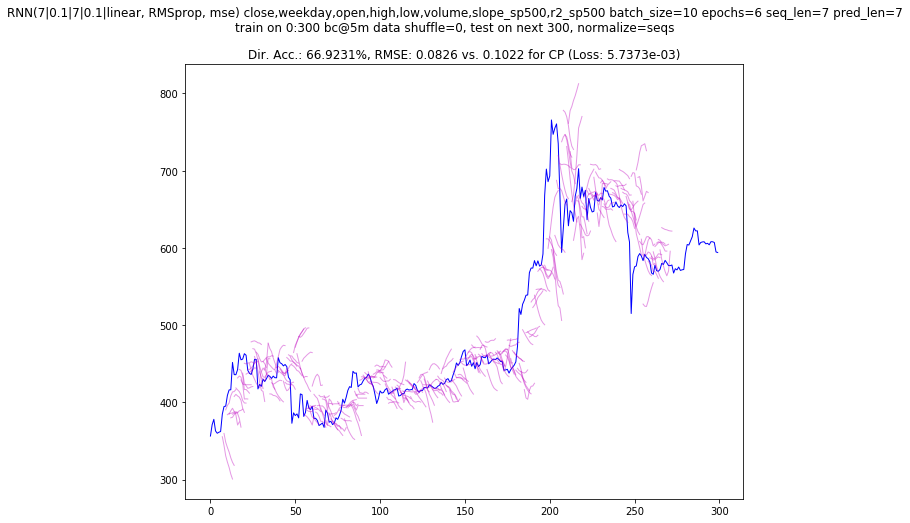

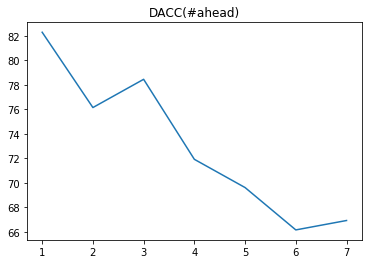

--- 23.237s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140028629593040
Tensor("lstm_135_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_135 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_135 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_136 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_136 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 

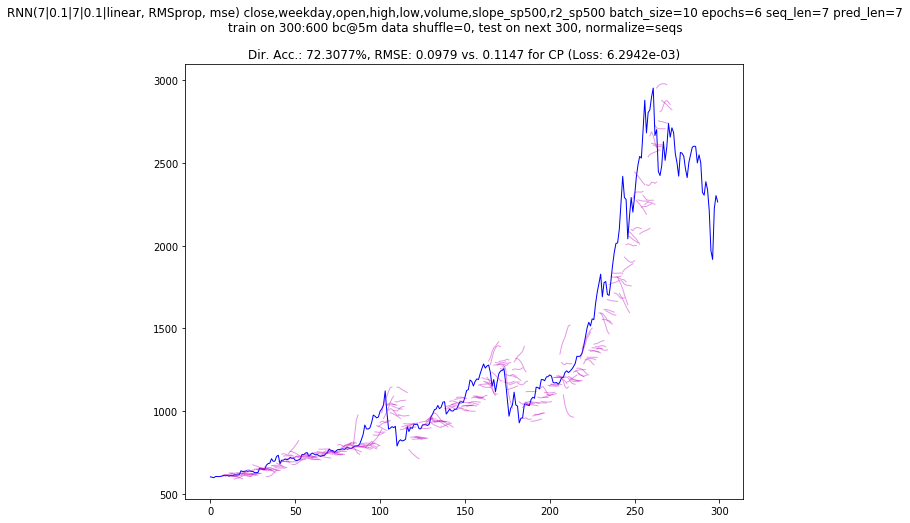

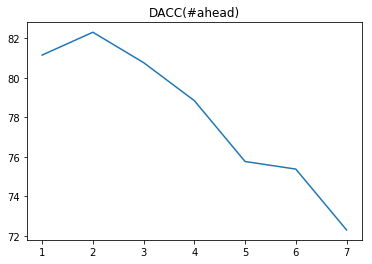

--- 23.093s to run segment


   ------ RUN 900 (from 600, train on 300, test on 300)

data ~ (600, 8)
--- 0.015s to model compilation time


--- Created model id: 140028601413264
Tensor("lstm_137_input:0", shape=(?, 7, 8), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_137 (LSTM)              (None, 7, 7)              448       
_________________________________________________________________
dropout_137 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_138 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_138 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 8         
Total params: 876
Trainable params: 

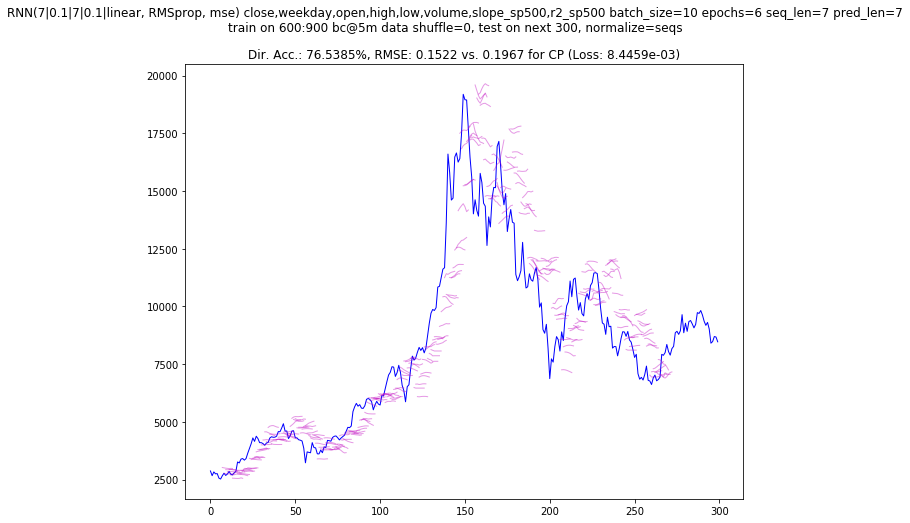

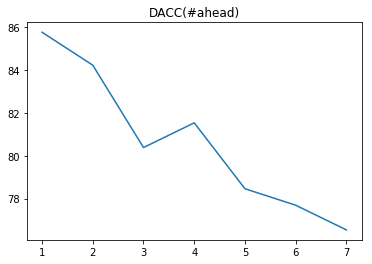

--- 23.330s to run segment

--- 69.660s to full run 300 - 1051



In [91]:
DEFAULT_PARAMS['features'] = ['close', 'weekday',
                 'open', 'high', 'low', 'volume',
                 'slope_sp500', 'r2_sp500']
full_run(300, 1051, write_csv_header=False)

In [92]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",0,300,300,False,seqs,0.007575,0.0837%,0.1022%,63.8462%
1,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",300,600,300,False,seqs,0.006591,0.1116%,0.1147%,73.4615%
2,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",600,900,300,False,seqs,0.008795,0.1593%,0.1967%,71.5385%
3,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",0,300,300,False,seqs,0.005737,0.0826%,0.1022%,66.9231%
4,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",300,600,300,False,seqs,0.006294,0.0979%,0.1147%,72.3077%
5,"RNN(7|0.1|7|0.1|linear, RMSprop, mse) close,we...",600,900,300,False,seqs,0.008446,0.1522%,0.1967%,76.5385%


In [93]:
(66.92 + 72.30 + 76.53) / 3

71.91666666666667

In [62]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",0,300,300,False,seqs,0.004466,0.0727%,0.1022%,70.0000%
1,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",300,600,300,False,seqs,0.004734,0.0834%,0.1147%,79.6154%
2,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",600,900,300,False,seqs,0.007003,0.1487%,0.1967%,77.3077%


In [30]:
(70.00 + 79.61 + 77.30) / 3

75.63666666666667